<a href="https://colab.research.google.com/github/RO-AD/waymo-od-motion-pred/blob/main/tutorial/2_waymo_official_tutorial/gp-waymo_official_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Waymo 공식 튜토리얼 실습

공식 튜토리얼이 오류가 좀 있어서 과거의 나에게 힘을 좀 빌렸다. 내맘대로 바꿔버리는 튜토리얼,,,ㅋ

- Waymo 공식 튜토리얼 : https://github.com/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial_motion.ipynb

- 과거의 재승 : https://github.com/RO-AD/waymo-od-motion-pred/blob/b0b831d8a54531056289b85fb91b509a78bd1a20/jaeseung/tutorial-1.ipynb

# 패키지 설치

## waymo_open_dataset 패키지 설치하기

In [1]:
%%capture
!rm -rf waymo-od > /dev/null # 레포가 이미 존재하면 지움
!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od
!cd waymo-od && git checkout remotes/origin/master

In [2]:
%%capture
!pip3 install --upgrade pip
!pip3 install waymo-open-dataset-tf-2-6-0

## Read one frame
하나의 프레임을 읽어보자. 파일이 어떻게 생겼고, 어떻게 읽을 수 있는지 알아본다

In [3]:
!ls -al ./waymo-od/tutorial/frames

-rw-r--r-- 1 root root 8577921 Mar 29 05:36 ./waymo-od/tutorial/frames


In [4]:
!xxd ./waymo-od/tutorial/frames | head

00000000: ae5a 4100 0000 0000 e0a5 4a4b 0aa8 150a  .ZA.......JK....
00000010: 2631 3130 3034 3638 3537 3339 3731 3435  &110046857397145
00000020: 3030 3232 305f 3233 3030 5f30 3030 5f32  00220_2300_000_2
00000030: 3332 305f 3030 3012 ee01 0801 11dd ef9b  320_000.........
00000040: bf1c 0fa0 4011 ddef 9bbf 1c0f a040 11d8  ....@........@..
00000050: 5892 7f42 5d8d 4011 e81f 42d4 9308 8440  X..B].@...B....@
00000060: 118f b145 4fb9 8ba0 3f11 41c3 45a9 0592  ...EO...?.A.E...
00000070: d4bf 11ba 4ac5 6e55 fe49 3f11 85b3 7881  ....J.nU.I?...x.
00000080: 2a81 44bf 1100 0000 0000 0000 001a 9001  *.D.............
00000090: 0935 29b1 f11e ffef 3f09 0c0a 38a1 558c  .5).....?...8.U.


In [5]:
import tensorflow.compat.v1 as tf

# Eager Execution 모드 활성화 -> 디버깅 용이 및 코드 실행속도 향상
tf.enable_eager_execution()

import numpy as np
from waymo_open_dataset import dataset_pb2 # pb : protocol buffers

FILENAME = '/content/waymo-od/tutorial/frames' # git repo 내에 있음
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
for data in dataset:
    frame = dataset_pb2.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    break

In [6]:
from waymo_open_dataset.utils import  frame_utils

(range_images, camera_projections, _, range_image_top_pose)\
  = frame_utils.parse_range_image_and_camera_projection(frame)

# 데이터셋 로드

## Google Drive 연동
일단 테스트용도로 validation 5개를 drive에 업로드 했다. 이를 가져온다.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!cp -r /content/drive/MyDrive/waymo-od-dataset/for_tutorial ./

In [9]:
!ls for_tutorial/

validation.tfrecord-00000-of-00150  validation.tfrecord-00003-of-00150
validation.tfrecord-00001-of-00150  validation.tfrecord-00004-of-00150
validation.tfrecord-00002-of-00150


In [10]:
!cd /content/drive/MyDrive/waymo-od-dataset/ &\
 ls -al ./for_tutorial/validation.tfrecord-00000-of-00150

-rw------- 1 root root 254565845 Mar 29 05:38 ./for_tutorial/validation.tfrecord-00000-of-00150


## python 코드로 데이터셋 읽기

데이터셋의 양이 너무 많고 크기 때문에, 데이터셋도 효율적으로 관리할 필요가 있다. Tensorflow는 TFRecord라는 형태의 파일로 관리할 수 있도록 하는데, 구조를 최소한으로 압축해서 보관하는 방식이다.

TFRecordDataset() 메소드는 이러한 TFRecord 형태의 데이터셋을 다룰 수 있도록 하는 메소드다.

In [11]:
DATASET_DIR = '/content/drive/MyDrive/waymo-od-dataset'
FILENAME = DATASET_DIR + '/for_tutorial/validation.tfrecord-00000-of-00150'

In [12]:
import tensorflow as tf

dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [13]:
for num_data, data in enumerate(dataset):
    pass

num_data

269

하나의 tfrecord 파일 내부에는 269개의 데이터가 있는 것을 알 수 있다.

### 데이터셋 구조 파일(proto)을 이용해서 로드하기

tfrecord 데이터셋은 압축된 형태로 존재한다. TFRecordDataset을 이용해서 tfrecord 데이터셋을 읽을 수 있으나, 압축을 해제할 수 있도록 구조 정의가 필요하다.

직접 정의할 수도 있으나, waymo-open-dataset 라이브러리를 이용하면 구조(proto)를 가져올 수 있다.

In [14]:
type(data)

tensorflow.python.framework.ops.EagerTensor

In [15]:
from waymo_open_dataset.protos import scenario_pb2

scenario = scenario_pb2.Scenario()
scenario.ParseFromString(data.numpy())

435428

In [16]:
scenario.scenario_id

'c12dd9b235799eb8'

구조 정의가 되었으니, 이를 기반으로 dataset을 해석할 수 있다. 한 개만 뽑아서 풀어본다.

# 시각화 이미지 생성

### 간단하게 map 데이터 출력해보기

In [17]:
import matplotlib.pyplot as plt

def poly2list(poly):
  '''
  polygon 데이터를 x,y,z 리스트로 분리하는 함수
  '''
  x, y, z = [], [], []
  for point in poly:
    x.append(point.x)
    y.append(point.y)
    z.append(point.z)
  return x, y, z

In [18]:
def visualizationMap(ax, map_features):
  for feature in map_features:
    #print("****", feature.id)
    
    lane_x, lane_y, lane_z = poly2list(feature.lane.polyline)
    ax.plot(lane_x, lane_y, '-', c='#d6d6d6', lw=1) # 도로부분이라서 연한 회색
    
    road_line_x, road_line_y, road_line_z = poly2list(feature.road_line.polyline)
    ax.plot(road_line_x, road_line_y, '--', c='gray') # 차선이라서 일단 회색 대시 선
    
    road_edge_x, road_edge_y, road_edge_z = poly2list(feature.road_edge.polyline)
    ax.plot(road_edge_x, road_edge_y, '-', c='black') # 엣지 부분은 검은 실선
    
    for point in [feature.stop_sign.position]:
        pass #ax.plot(point.x, point.y, marker='o', c='red', ms=10) # 데이터가 좀 이상함,,,
    
    crosswalk_x, crosswalk_y, crosswalk_z = poly2list(feature.crosswalk.polygon)
    ax.plot(crosswalk_x, crosswalk_y, '-', c='#f1f289', lw=2)
    
    speed_bump_x, speed_bump_y, speed_bump_z = poly2list(feature.speed_bump.polygon)
    ax.plot(speed_bump_x, speed_bump_y, '-', c='#fab6e6', lw=2)

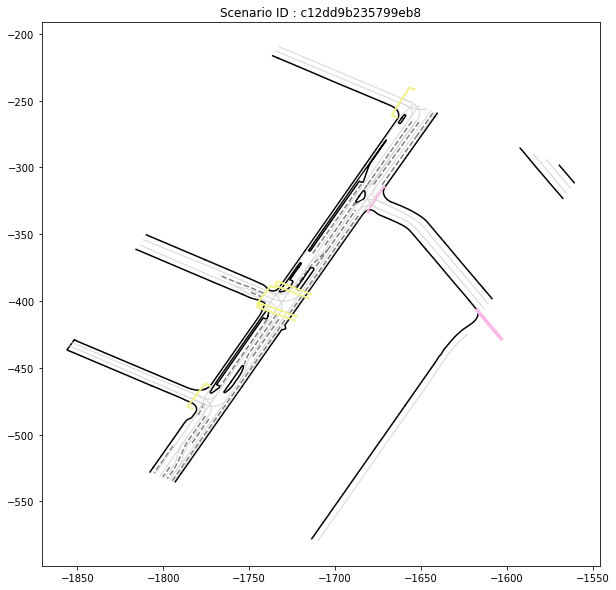

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.title.set_text("Scenario ID : " + scenario.scenario_id)

visualizationMap(ax, scenario.map_features)

### Agent도 출력해보기

In [20]:
mission_x, mission_y, mission_z = [], [], [] # 예측해야하는 객체
state_x, state_y, state_z       = [], [], [] # 일반 객체
for track in scenario.tracks:
  state = track.states[0] # 0번째 Frame만 보여주기 (영상이 아니라서)
  if state.valid:
    if track.id in scenario.objects_of_interest:
      mission_x.append(state.center_x)
      mission_y.append(state.center_y)
      mission_z.append(state.center_z)
    else:
      state_x.append(state.center_x)
      state_y.append(state.center_y)
      state_z.append(state.center_z)
  else:
    pass #print("ERROR :: Invalid track state")

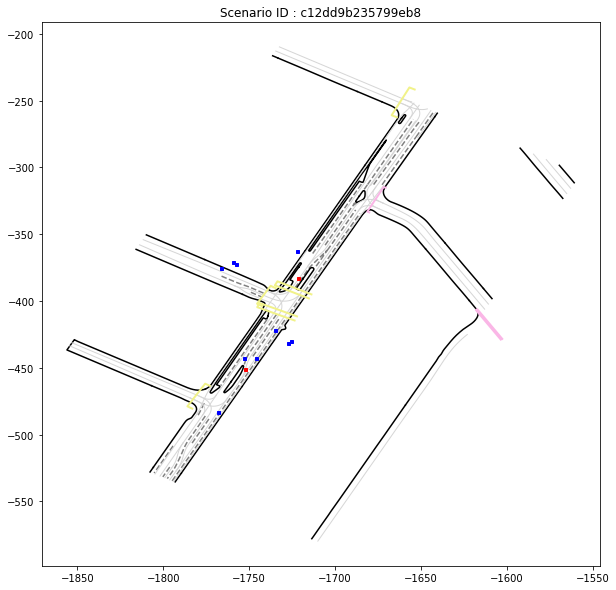

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.title.set_text("Scenario ID : " + scenario.scenario_id)

visualizationMap(ax, scenario.map_features)

# Agent 출력
objs,    = ax.plot(state_x,   state_y,   's', c='blue', ms=3)
mission, = ax.plot(mission_x, mission_y, 's', c='red',  ms=3)

# Simple MLP로 학습시켜보기 (with. TF)



문제 자체가 복잡해서 간단한 MLP로는 택도 없지만 일단 모델을 만들어보면서 감을 익혀본다

In [22]:
DATASET_DIR = '/content/drive/MyDrive/waymo-od-dataset'
FILENAME = DATASET_DIR + '/for_tutorial/validation.tfrecord-00000-of-00150'

# 데이터셋 로드
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')

In [ ]:
def _parse(data):
  """ 데이터셋을 모델의 Input 형태에 맞게 파싱하는 함수 """
  scenario = scenario_pb2.Scenario()
  scenario.ParseFromString(data.numpy())
  

# 테스트
for idx, data in enumerate(dataset):
  _parse(data)
  break

In [ ]:
# tutorial/2_waymo_official_tutorial/gp-waymo_official_tutorial.ipynb